In [4]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import os


from ML_Model.runModel import runModel
from ML_Model.findContours import findContours

In [ ]:
# Run the model to find the lesion
model_name = 'ML_Model/lesion_finder_v1.pth'
data_dir = 'Lesion_Data'
positions = os.listdir(data_dir)
positions.sort()
positions.remove('.DS_Store')

master_matrix = np.empty((len(positions), 30, 512, 512), dtype=np.uint8)
# some kind of structure to store the images (npz?)
for i, position in enumerate(positions):
    sample_dir = os.path.join(data_dir, position)
    
    predicted_targets = runModel(sample_dir, model_name)

    master_matrix[i] = predicted_targets

# saved a copy of the predictions as .npz so this cell doesn't need to be run every time 
# file = np.load('master_matrix.npz')
# master_matrix = file['master_matrix']

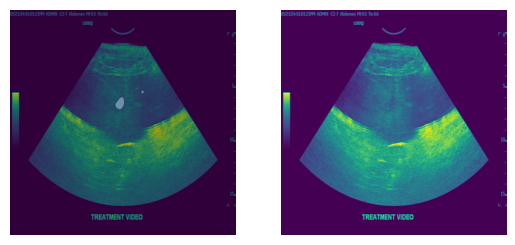

In [27]:
# Visualize the model output
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from ML_Model.customDataset import RunDataset

sample_dir = 'Lesion_Data/Position 07/'

if master_matrix is None:
    file = np.load('master_matrix.npz')
    master_matrix = file['master_matrix']
first_pred = master_matrix[6][0]

# This little block of code is to get the first sample image. It's inefficient but I'm lazy
run_transformations = v2.Compose(
        [v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize(size=[512,512]),
        v2.Normalize(mean=[0.0], std=[1.0])]
)
test_dataset = RunDataset(sample_dir, run_transformations)
test_loader = DataLoader(test_dataset, 1, False)
test_sample = iter(test_loader)
sample = next(test_sample)


fig, ax = plt.subplots(1, 2)
ax[0].imshow(sample[0][0], alpha=1.0)
ax[0].imshow(first_pred, alpha=0.3, cmap='gray')
ax[0].axis('off')
ax[1].imshow(sample[0][0])
ax[1].axis('off')

plt.show()

In [29]:
# Find the contours of the predicted targets
import cv2
import numpy as np
import pickle

predicted_targets = np.load('mask_master_matrix.npz')

edge_coords = {slice: {} for slice in range(predicted_targets.shape[0])}

theta = np.arange(0, np.pi, np.pi/12) # There are 12 division of the imager holder
            
for slice_num in edge_coords.keys():
    for time_point in range(predicted_targets.shape[1]):
        
        contours, _ = cv2.findContours(image=predicted_targets[slice_num][time_point],
                                    mode=cv2.RETR_EXTERNAL,
                                    method=cv2.CHAIN_APPROX_NONE
                                    )

        # Store the coordinates of all the contours in the coordinates array. 
        slice_coords = np.empty((0, 2), dtype=int)
        for contour in contours:
            slice_coords = np.vstack((slice_coords, contour.reshape(-1, 2)))

        # Apply a rotation, theta, around the x axis
        centroid_x = np.mean(slice_coords[:, 0])

        # Shift the contour to be 'centered' on (0, 0) then perform a rotation around the x axis
        shifted_x = slice_coords[:, 0] - centroid_x
        
        # initialize a z coordinate
        z = np.zeros_like(shifted_x)

        # perform a rotation around the y axis based on the slice
        
        transform = np.array([
            [np.cos(theta[slice_num]), np.sin(theta[slice_num])],
            [-np.sin(theta[slice_num]), np.cos(theta[slice_num])]
            ])
        
        XandZ = np.column_stack((shifted_x, z))
        XandZ = XandZ.T

        rotated_points = transform @ XandZ
        rotated_points = rotated_points.T

        # Note this if statement is there to rectify the mispositioning of the imager in the first 3 rotational positions
        # Under normal circumstance, this is not needed
        if slice_num in [0, 1, 2]:
            slice_coords = np.column_stack((rotated_points[:, 0] + centroid_x, slice_coords[:, 1] -50, rotated_points[:, 1]))
        else:
            slice_coords = np.column_stack((rotated_points[:, 0] + centroid_x, slice_coords[:, 1], rotated_points[:, 1]))
        

        edge_coords[slice_num][time_point] = slice_coords # add each time point's coords to the correct slice in the dict  

with open('ideal_edge_coords.pkl', 'wb') as file:
    pickle.dump(edge_coords, file)

/Users/joel/Files/VS Code/RespMotion/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joel/Files/VS Code/RespMotion/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
# Building the idealized case with the manually segmented masks

import numpy as np
from PIL import Image
import os

Lesion_masks = os.listdir('Lesion_Masks')
Lesion_masks.sort()
Lesion_masks.remove('.DS_Store')

mask_master_matrix = np.zeros((12, 30, 512, 512), dtype=np.uint8)

for i, position in enumerate(Lesion_masks):
    masks_dir = os.path.join('Lesion_masks', position)
    masks = os.listdir(masks_dir)
    masks.sort()
    masks.remove('.DS_Store')

    for j, mask in enumerate(masks):
        mask_path = os.path.join(masks_dir, mask)
        with Image.open(mask_path) as img:
            img = img.convert('L')
            img = img.resize((512, 512))
            mask_master_matrix[i][j] = np.array(img)




In [ ]:
# Visualize the contours



In [6]:
# Construct a volume from the contours
import pickle
import numpy as np
from scipy.spatial import Delaunay
from ML_Model.findSteeringLocations import findSteeringLocations

with open('ideal_edge_coords.pkl', 'rb') as file:
    edge_coords = pickle.load(file)

spacing = 4 # currently don't know what this translates to in cm
steering_coords = {}
for time_point in edge_coords[0].keys():
    all_points = []
    for position in edge_coords.keys():
        all_points.append(edge_coords[position][time_point])
    steering_coords[time_point] = findSteeringLocations(all_points, spacing)


# Export volume to visualize externally

# with open('steering_coords.pkl', 'wb') as file:
    # pickle.dump(steering_coords, file)

In [7]:
with open('steering_coords.pkl', 'wb') as file:
    pickle.dump(steering_coords, file)

Above this point is where all the real stuff is happening. Below it is for testing purposes and fiddling around

In [25]:
# Improved data augmentation - imports
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2, InterpolationMode
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

from ML_Model.customDataset import TrainTestDataset

In [99]:
# Improved data augmentation - the meat and bones
# https://pmc.ncbi.nlm.nih.gov/articles/PMC9966095/ --> review paper on data segmentation techniques

transforms_1 = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=[512,512]),
    v2.RandomRotation(degrees=360, interpolation=InterpolationMode.BILINEAR),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.Normalize(mean=[0.0], std=[1.0])
])

transforms_2 = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=[512,512]),
    v2.RandomRotation(degrees=360, interpolation=InterpolationMode.BILINEAR),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.Normalize(mean=[0.0], std=[1.0]),
    v2.GaussianBlur(kernel_size=(13, 13), sigma=3.0)
])

transforms_3 = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=[512,512]),
    v2.RandomRotation(degrees=360, interpolation=InterpolationMode.BILINEAR),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.Normalize(mean=[0.0], std=[1.0]),
    v2.GaussianBlur(kernel_size=(13, 13), sigma=3.0),
    v2.RandomCrop(size=300)
])

transforms_4 = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=[512,512]),
    v2.RandomRotation(degrees=360, interpolation=InterpolationMode.BILINEAR),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.Normalize(mean=[0.0], std=[1.0]),
    v2.RandomPerspective(distortion_scale=0.5, p=1),
    v2.RandomAdjustSharpness(sharpness_factor=10, p=1),
    v2.RandomCrop(size=350)
])

test_set = TrainTestDataset(sample_dir='transforms images/sample', mask_dir='transforms images/mask', transform=transforms_4)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

iterator = iter(test_loader)
sample, mask = next(iterator)


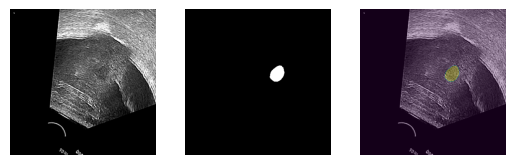

In [100]:
# Improved data augmentation - pretty pictures

fig, ax = plt.subplots(1, 3)
ax[0].imshow(sample[0][0], alpha=1.0, cmap='gray')
ax[0].axis('off')
ax[1].imshow(mask[0][0], cmap='gray')
ax[1].axis('off')
ax[2].imshow(sample[0][0], alpha=1.0, cmap='gray')
ax[2].imshow(mask[0][0], alpha=0.3)
ax[2].axis('off')

plt.show()

541391595
<class 'NoneType'>
